In [1]:
import dask.dataframe as dd
import gc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Cargar el DataFrame desde el archivo Parquet utilizando Dask
data_dd = dd.read_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM\data.parquet', engine='pyarrow')

In [2]:
# Separar características y etiquetas de la muestra
X = data_dd['susceptibilidad']
y = data_dd['inventario']

In [3]:
# Convertir los datos de Dask a pandas para el preprocesamiento
X_pd = X.compute().values.reshape(-1, 1)
y_pd = y.compute()

In [4]:
# Primero, separar un conjunto de prueba directamente del conjunto original
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)

In [5]:
# Luego, dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [6]:
# Aplicar SMOTE para balancear el conjunto de entrenamiento
smote = SMOTE(random_state=42, n_jobs=-1)  # Usar todos los núcleos disponibles
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\HOME\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [7]:
# Convertir los datos a float32 para ahorrar memoria
X_train_resampled = X_train_resampled.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# Liberar memoria de los conjuntos originales
del X_train, y_train, X_pd, y_pd
gc.collect()

41

In [9]:
# Crear DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
# Definir los parámetros a explorar en la búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 6, 10, 15, 20],  # Aumentar el rango de profundidad de los árboles
    'min_child_weight': [1, 3, 5, 7],  # Incluir más opciones de pesos mínimos de los nodos hijo
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Ampliar el rango de regularización para los nodos
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Más opciones de submuestreo de datos
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Más opciones de submuestreo de columnas
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Incluir tasas de aprendizaje más bajas
    'scale_pos_weight': [1, len(y_train_resampled) / sum(y_train_resampled)],  # Ajustar para el desbalance de clases
    'n_estimators': [50, 100, 200, 300, 500],  # Aumentar el número de estimadores
    'tree_method': ['hist', 'approx', 'auto'],  # Añadir diferentes métodos de construcción del árbol
    'reg_alpha': [0, 0.1, 0.5, 1],  # Regularización L1
    'reg_lambda': [1, 1.5, 2, 3],  # Regularización L2
    'max_delta_step': [0, 1, 2, 3],  # Ayuda en problemas desbalanceados
    'objective': ['binary:logistic', 'binary:hinge'],  # Probar diferentes objetivos de clasificación binaria
    'scale_pos_weight': [1, len(y_train_resampled) / sum(y_train_resampled), 5, 10],  # Ajuste fino para clases desbalanceadas
    'booster': ['gbtree', 'gblinear', 'dart']  # Diferentes tipos de boosters
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,  # Deshabilitar advertencias por codificación de etiquetas
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Configurar la búsqueda de hiperparámetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Aumentar el número de combinaciones a probar para una búsqueda más exhaustiva
    scoring='roc_auc',  # Optimizar para el AUC-ROC
    cv=5,  # Aumentar la validación cruzada para mayor robustez
    verbose=3,  # Aumentar la verbosidad para más información durante la búsqueda
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train_resampled, y_train_resampled)

# Mostrar los mejores hiperparámetros encontrados
print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\HOME\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'tree_method': 'approx', 'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.5, 'objective': 'binary:logistic', 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 20, 'max_delta_step': 1, 'learning_rate': 0.001, 'gamma': 0.3, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


In [11]:
# Entrenar el modelo con los mejores hiperparámetros y early stopping
best_model = random_search.best_estimator_

In [12]:
# Configurar los hiperparámetros incluyendo 'eval_metric' en la definición del modelo
best_model.set_params(**{
    'eval_metric': 'aucpr',  # AUC Precision-Recall como métrica
    'early_stopping_rounds': 10,  # Early stopping
    'use_label_encoder': False  # Para evitar advertencias
})

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=20, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [13]:
# Entrenar el modelo utilizando los conjuntos de entrenamiento y validación
best_model.fit(
    X_train_resampled, 
    y_train_resampled, 
    eval_set=[(X_val, y_val)], 
    verbose=True
)

[0]	validation_0-aucpr:0.25521
[1]	validation_0-aucpr:0.25438
[2]	validation_0-aucpr:0.24971
[3]	validation_0-aucpr:0.25193
[4]	validation_0-aucpr:0.25184
[5]	validation_0-aucpr:0.25181
[6]	validation_0-aucpr:0.25119
[7]	validation_0-aucpr:0.25052
[8]	validation_0-aucpr:0.25022
[9]	validation_0-aucpr:0.25058
[10]	validation_0-aucpr:0.24937


c:\Users\HOME\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=20, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [14]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba > 0.5).astype(int)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation ROC AUC: {val_roc_auc}')

Validation Accuracy: 0.5575603557814486
Validation ROC AUC: 0.49845022682750806


In [15]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test ROC AUC: {test_roc_auc}')

Test Accuracy: 0.5708841463414634
Test ROC AUC: 0.5003961909098593


In [16]:
# Reporte de clasificación en el conjunto de prueba
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.64      0.69      2955
         1.0       0.25      0.36      0.29       981

    accuracy                           0.57      3936
   macro avg       0.50      0.50      0.49      3936
weighted avg       0.63      0.57      0.59      3936



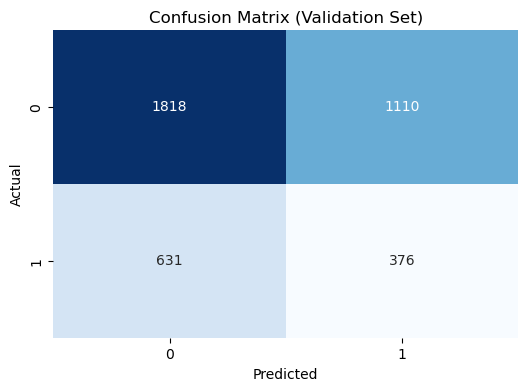

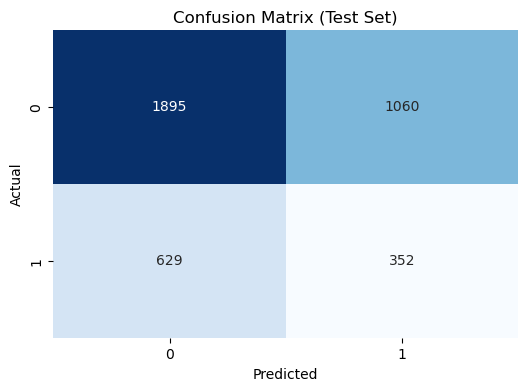

In [17]:
# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, set_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({set_name})')
    plt.show()

# Matriz de confusión para el conjunto de validación
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')

# Matriz de confusión para el conjunto de prueba
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')